
Processing Column 1: SR
Slope m = -0.461  =>  beta ≈ 0.461
β uncertainty = ±0.078


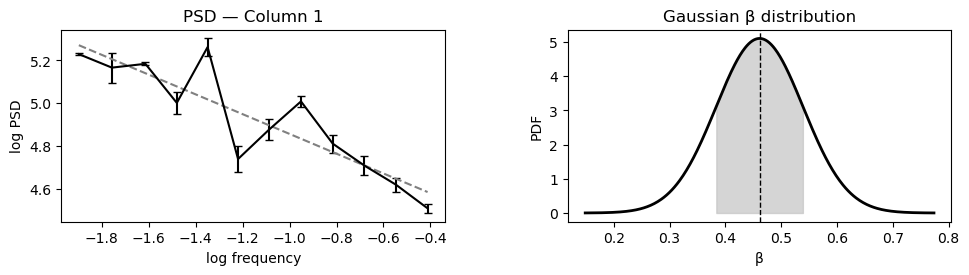


Processing Column 2: PCA
Slope m = -0.644  =>  beta ≈ 0.644
β uncertainty = ±0.048


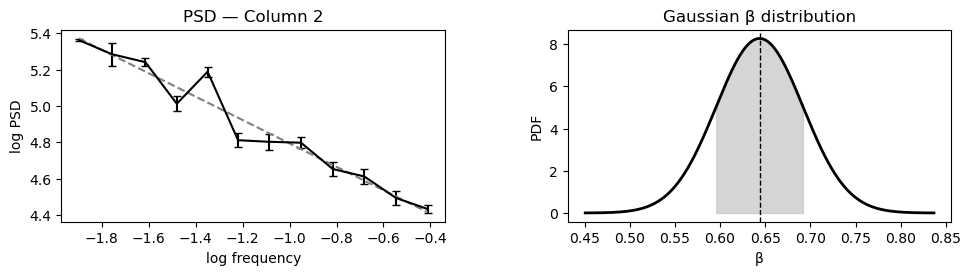


Processing Column 3: KNN
Slope m = -0.605  =>  beta ≈ 0.605
β uncertainty = ±0.059


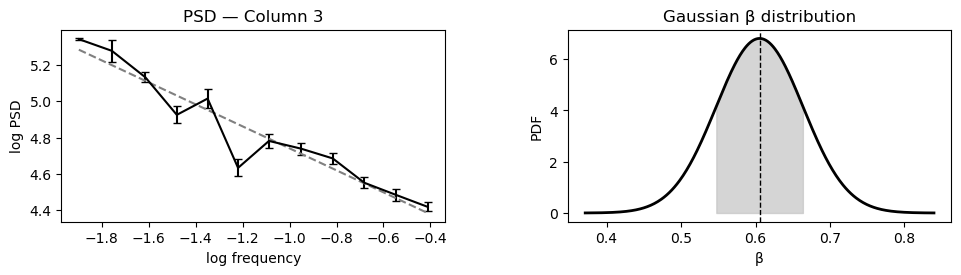


Processing Column 4: NN
Slope m = -0.667  =>  beta ≈ 0.667
β uncertainty = ±0.050


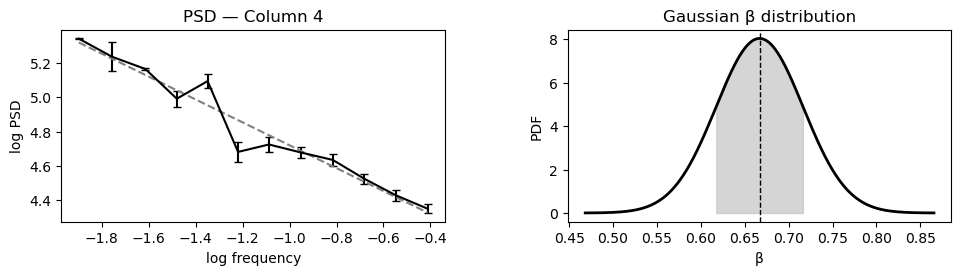

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal.windows import dpss
from scipy.stats import linregress
import math

def detrend_anomaly(y):
    x = np.arange(len(y))
    m, b = np.linalg.lstsq(np.vstack([x, np.ones_like(x)]).T, y, rcond=None)[0]
    y = y - (m * x + b)
    return y - np.mean(y)

def mtm_psd(y, dt=1.0, NW=3.0, K=None, adaptive=True, nfft=None):
    y = np.asarray(y, float)
    N = len(y)
    if nfft is None:
        nfft = int(2 ** np.ceil(np.log2(N)))
    if K is None:
        K = int(2 * NW - 1)  # 5 for NW=3
    tapers, eigs = dpss(N, NW, K, return_ratios=True)
    x = detrend_anomaly(y)

    Sk = []
    for k in range(K):
        Xk = np.fft.rfft(x * tapers[k], n=nfft)
        Sk.append((np.abs(Xk) ** 2) / (N / dt))  
    Sk = np.array(Sk)

    wk = eigs[:, None] / np.sum(eigs)
    S = np.sum(wk * Sk, axis=0)
    freqs = np.fft.rfftfreq(nfft, d=dt)
    return freqs, S

# ---------- Log-binning utility ----------
def logbin(x, y, nbins=14, xmin=None, xmax=None):
    """Logarithmically bin (x,y) by x; return bin centers, mean(log10 y), stderr."""
    x = np.asarray(x); y = np.asarray(y)
    mask = (x > 0) & np.isfinite(y) & (y > 0)
    x = x[mask]; y = y[mask]

    if xmin is None: xmin = x.min()
    if xmax is None: xmax = x.max()

    # log-spaced bin edges
    edges = np.logspace(np.log10(xmin), np.log10(xmax), nbins + 1)
    xc, ym, ys = [], [], []
    for i in range(nbins):
        m = (x >= edges[i]) & (x < edges[i+1])
        if m.sum() < 2:  # need >=2 to show errorbars
            continue
        # geometric mean for x center (typical on log axis)
        xc.append(10 ** np.mean(np.log10(x[m])))
        logs = np.log10(y[m])
        ym.append(np.mean(logs))
        ys.append(np.std(logs, ddof=1) / np.sqrt(m.sum()))  # standard error
    return np.array(xc), np.array(ym), np.array(ys)

# ---------- Main ----------
# ---------- Two side-by-side subplots ----------
# ---------- Main ----------
if __name__ == "__main__":

    excel_path = "Reconstruction New.xlsx"
    df_raw = pd.read_excel(excel_path, sheet_name=0, header=0)

    years = pd.to_numeric(df_raw.iloc[:, 0], errors="coerce")

    # Process columns 1 through 5
    for col_idx in range(1, 5):
        print("\n============================")
        print(f"Processing Column {col_idx}: {df_raw.columns[col_idx]}")
        print("============================")

        flow = pd.to_numeric(df_raw.iloc[:, col_idx], errors="coerce")

        df = pd.DataFrame({"Year": years, "Flow": flow}).dropna()
        df = df[(df["Year"] >= 1490) & (df["Year"] <= 1995)]
        df = df.drop_duplicates("Year").sort_values("Year")

        full_years = np.arange(1490, 1995 + 1)
        flow_full = np.interp(full_years, df["Year"].values, df["Flow"].values)

        freqs, S = mtm_psd(flow_full, dt=1.0, NW=3.0, K=5, adaptive=False)

        m = (freqs > 0) & (freqs <= 0.5)
        f, P = freqs[m], S[m]

        fmin = max(f.min(), 1.0 / 200.0)
        fmax = 0.45
        sel = (f >= fmin) & (f <= fmax)

        xb, yb, yerr = logbin(f[sel], P[sel], nbins=14)

        # regression
        x_log = np.log10(xb)
        res = linregress(x_log, yb)
        m_slope = res.slope
        a_inter = res.intercept
        beta = -m_slope
        stderr_m = res.stderr

        print(f"Slope m = {m_slope:.3f}  =>  beta ≈ {beta:.3f}")
        print(f"β uncertainty = ±{stderr_m:.3f}")

        # ----------- FIGURE: Left (PSD) + Right (Gaussian) ----------
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
        plt.subplots_adjust(left=0.08, right=0.97, wspace=0.32, bottom=0.18, top=0.82)

        # --- LEFT PANEL: PSD ---
        ax1.errorbar(x_log, yb, yerr=yerr, fmt='k-', lw=1.5, capsize=3)

        xx = np.linspace(x_log.min(), x_log.max(), 300)
        yy = a_inter + m_slope * xx
        ax1.plot(xx, yy, '--', lw=1.5, color='gray')

        ax1.set_xlabel("log frequency")
        ax1.set_ylabel("log PSD")
        ax1.set_title(f"PSD — Column {col_idx}")

        # --- RIGHT PANEL: Gaussian of β ---
        beta_mean = beta
        beta_sigma = stderr_m

        beta_min = beta_mean - 4 * beta_sigma
        beta_max = beta_mean + 4 * beta_sigma
        beta_grid = np.linspace(beta_min, beta_max, 400)

        gauss = (1.0 / (np.sqrt(2 * np.pi) * beta_sigma)) * \
                np.exp(-0.5 * ((beta_grid - beta_mean) / beta_sigma) ** 2)

        ax2.plot(beta_grid, gauss, 'k-', lw=2)
        ax2.fill_between(
            beta_grid,
            0,
            gauss,
            where=(beta_grid >= beta_mean - beta_sigma) & (beta_grid <= beta_mean + beta_sigma),
            color='#C4C4C4',  # ash color
            alpha=0.7,
        )

        ax2.axvline(beta_mean, ls='--', color='k', lw=1)
        ax2.set_xlabel("β")
        ax2.set_ylabel("PDF")
        ax2.set_title("Gaussian β distribution")

        plt.show()


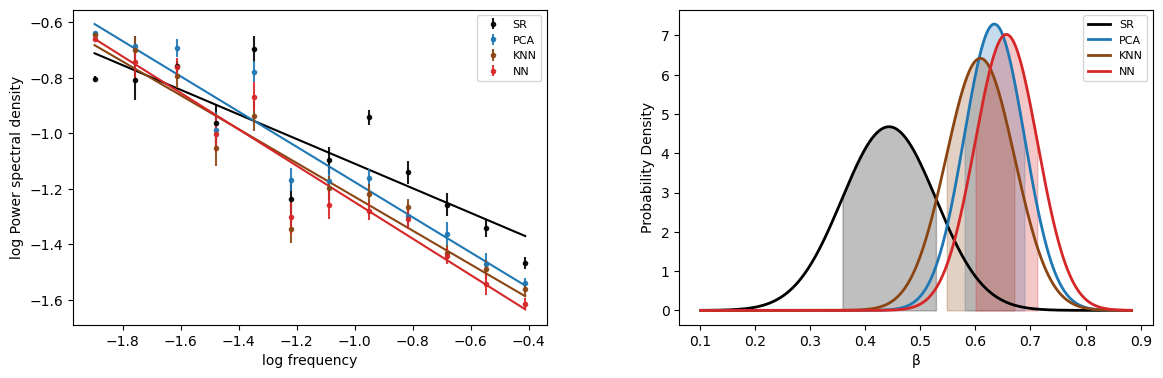

In [5]:
if __name__ == "__main__":

    excel_path = "Reconstruction New.xlsx"
    df_raw = pd.read_excel(excel_path, sheet_name=0, header=0)
    years = pd.to_numeric(df_raw.iloc[:, 0], errors="coerce")

    # Storage for ALL 5 models
    psd_x_list = []
    psd_y_list = []
    psd_yerr_list = []
    beta_mean_list = []
    beta_sigma_list = []

    # Column names for legend
    method_names = [
        "SR",
        "PCA",
        "KNN",
        "NN",
        "Hidalgo"
    ]

    colors = [
    "#000000",  # black
    "#1F77B4",  # ash gray
    "#8B4513",  # brown
    "#D62728",  # red
]

    # Loop through flow columns 1 → 5
    for col_idx in range(1, 5):

        flow = pd.to_numeric(df_raw.iloc[:, col_idx], errors="coerce")/10e2

        df = pd.DataFrame({"Year": years, "Flow": flow}).dropna()
        df = df[(df["Year"] >= 1493) & (df["Year"] <= 1962)]
        df = df.drop_duplicates("Year").sort_values("Year")

        full_years = np.arange(1493, 1962 + 1)
        flow_full = np.interp(full_years, df["Year"].values, df["Flow"].values)

        freqs, S = mtm_psd(flow_full, dt=1.0, NW=3.0, K=5, adaptive=False)

        m = (freqs > 0) & (freqs <= 0.5)
        f, P = freqs[m], S[m]

        fmin = max(f.min(), 1.0 / 200.0)
        fmax = 0.45
        sel = (f >= fmin) & (f <= fmax)

        xb, yb, yerr = logbin(f[sel], P[sel], nbins=14)

        # Regression
        x_log = np.log10(xb)
        res = linregress(x_log, yb)
        m_slope = res.slope
        a_inter = res.intercept
        beta = -m_slope
        stderr_m = res.stderr

        # Store everything
        psd_x_list.append(x_log)
        psd_y_list.append(yb)
        psd_yerr_list.append(yerr)
        beta_mean_list.append(beta)
        beta_sigma_list.append(stderr_m)

    # ==========================================================
    # COMBINED 1×2 PLOT FOR ALL 5 METHODS
    # ==========================================================

    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 4.5))
    plt.subplots_adjust(left=0.07, right=0.97, bottom=0.18, top=0.88, wspace=0.28)

    # ===== LEFT PANEL: PSD curves =====
    for i in range(4):
        ax_left.errorbar(
            psd_x_list[i],
            psd_y_list[i],
            yerr=psd_yerr_list[i],
            fmt='o',
            markersize=3,
            color=colors[i],
            alpha=0.9,
            label=method_names[i],
        )

        # regression line
        xx = np.linspace(psd_x_list[i].min(), psd_x_list[i].max(), 300)
        m_slope = np.polyfit(psd_x_list[i], psd_y_list[i], 1)[0]
        a_inter = np.polyfit(psd_x_list[i], psd_y_list[i], 1)[1]
        yy = a_inter + m_slope * xx

        ax_left.plot(xx, yy, color=colors[i], lw=1.5)

    ax_left.set_xlabel("log frequency")
    ax_left.set_ylabel("log Power spectral density")
    #ax_left.set_title("Power Spectral Density")
    ax_left.legend(fontsize=8)

    # ===== RIGHT PANEL: Gaussian β curves =====
    beta_grid = np.linspace(
        min(beta_mean_list[i] - 4 * beta_sigma_list[i] for i in range(4)),
        max(beta_mean_list[i] + 4 * beta_sigma_list[i] for i in range(4)),
        600
    )

    for i in range(4):
        mu = beta_mean_list[i]
        sig = beta_sigma_list[i]

        gauss = (1.0 / (np.sqrt(2 * np.pi) * sig)) * np.exp(-0.5 * ((beta_grid - mu) / sig)**2)

        ax_right.plot(beta_grid, gauss, color=colors[i], lw=2, label=method_names[i])
        ax_right.fill_between(
            beta_grid, 0, gauss,
            where=(beta_grid >= mu - sig) & (beta_grid <= mu + sig),
            color=colors[i], alpha=0.25
        )

    ax_right.set_xlabel("β")
    ax_right.set_ylabel("Probability Density")
    #ax_right.set_title("β Distributions")
    ax_right.legend(fontsize=8)

    plt.show()
